Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

In [482]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import warnings
import statsmodels.api as sm
import math
import statsmodels.stats.power as smp
from statsmodels.stats import proportion


from tqdm.auto import tqdm  # будет показывать количество итераций
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
warnings.filterwarnings("ignore", category=UserWarning) 

In [483]:
# Проведем EDA
df = pd.read_csv('результаты А_B - cookie_cats 2.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [484]:
# Оценим количество NULL и дубликатов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [485]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
90184    False
90185    False
90186    False
90187    False
90188    False
Length: 90189, dtype: bool

Ввиду равных длин обоих массивов - дубликаты, пропуски данных отсутствуют

In [486]:
# Оценим распределение пользователей по группам
sns_df=df.groupby('version', as_index=False).agg({'version': 'count' })                                   
sns_df['group'] = ['gate_30', 'gate_40']
sns_df = sns_df.rename(columns={'version': 'count'})
sns_df

,count,group
0,44700,gate_30
1,45489,gate_40


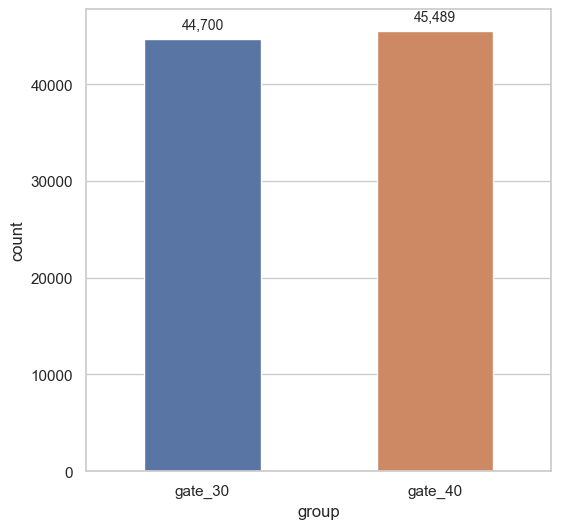

In [487]:
# Построим график распределения пользователей на контрольную и тестовую группу
plt.figure(figsize=(6,6))
control_count = df[df['version'] == 'gate_30']['version'].count()
test_count = df[df['version'] == 'gate_40']['version'].count()

ax = sns.barplot(data=sns_df, 
            x='group', 
            y='count', 
            hue='group', 
            width=0.5, 
            gap=0.001)
for p in ax.patches:
    ax.annotate(format(int(p.get_height()), ','),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points',
                fontsize=10)

plt.show()

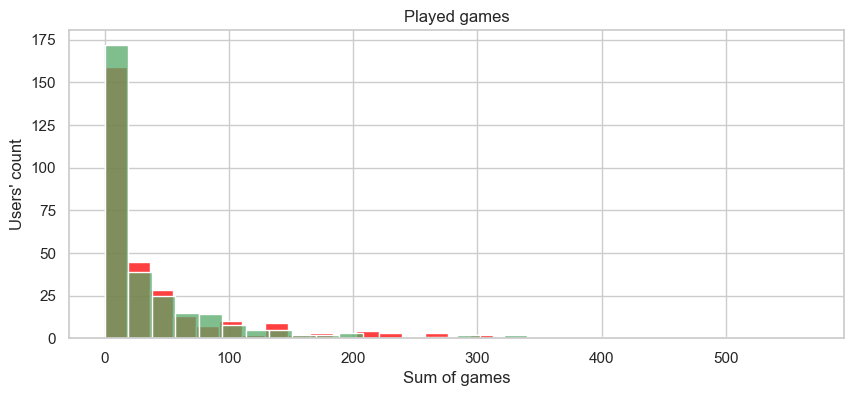

In [488]:
# Оценим распределение суммы наигранных раундов пользователями
plt.figure(figsize=(10,4))
sns.set_theme(style='whitegrid')

ax = sns.histplot(data=df['sum_gamerounds'][(df['version'] == 'gate_30')][:300], color='red', bins=30)
sns.histplot(data=df['sum_gamerounds'][(df['version'] == 'gate_40')][:300], color='g', bins=30)

ax.set(xlabel="Sum of games",
       ylabel="Users' count",
       title='Played games')
plt.show()

Распределение не является нормальным. В связи с этим используем непараметрические статистические методы

Тест для версии и возврата на первые сутки

In [489]:
# Расчитаем количество пользователей по вариантам и уровень возврата на первые сутки
k1 = df[df['version'] == 'gate_30']['retention_1'].sum()
k2 = df[df['version'] == 'gate_40']['retention_1'].sum()
n1 = df[df['version'] == 'gate_30'].shape[0]
n2 = df[df['version'] == 'gate_40'].shape[0]

In [490]:
# Расчет pvalue для группы retention_1
chisq, pvalue_1, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                   np.array([n1, n2]))
print('Results are:','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue_1))

Results are: chisq =3.183, pvalue = 0.074


In [491]:
if abs(pvalue_1) < 0.05:
    print("We may reject the null hypothesis about differencies between group and retention_1!")
else:
    print("We have failed to reject the null hypothesis about differencies between group and retention_1")

We have failed to reject the null hypothesis about differencies between group and retention_1


Оценим мощность теста возврата пользователей на 1 сутки

In [492]:
# Критерий пропорций (для кликов, конверсий)
p_control = df[df['version'] == 'gate_30']['retention_1'].sum()/control_count
p_test = df[df['version'] == 'gate_40']['retention_1'].sum()/test_count

n_control = len(df[df['version'] == 'gate_30'])
n_test = len(df[df['version'] == 'gate_40'])
n = sorted([n_control, n_test])

alpha = 0.05
power = 0.8   
p_control           # % Retenrion_1_gate30.
p_test              # % Retenrion_1_gate40.
p_test
n[0]            # количество наблюдений (мин)  

44700

In [493]:
# effect_size
h = 2 * math.asin(np.sqrt(p_control)) - 2 * math.asin(np.sqrt(p_test))
h

0.011881898259223478

In [494]:
# Мощность критерия для выборки из n элементов, если effect_size = h, alpha = 5%

power = smp.zt_ind_solve_power(effect_size=h, nobs1=n[0], alpha=alpha, alternative='two-sided')
power  # Низкая статистическая мощность теста 

0.4272451872776839

In [495]:
# Расчитаем количество юзеров, необходимых для тестирования гипотезы при мощности 0.8
nobs2 = smp.zt_ind_solve_power(effect_size=h, alpha=alpha, power=0.8, alternative='two-sided')
print("Число юзеров для достижения статистической мощности теста 80%: {:.0f}".format(nobs2+control_count))

Число юзеров для достижения статистической мощности теста 80%: 155890


Тест для версии и возврата на седьмые сутки

In [496]:
# Расчитаем количество пользователей по вариантам и уровень возврата на седьмые сутки
k7_30 = df[df['version'] == 'gate_30']['retention_7'].sum()
k7_40 = df[df['version'] == 'gate_40']['retention_7'].sum()

In [497]:
# Расчет pvalue для группы retention_7
chisq, pvalue_7, table = proportion.proportions_chisquare(np.array([k7_30, k7_40]), 
                                                   np.array([n1, n2]))
print('Results are:','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue_7))

Results are: chisq =10.013, pvalue = 0.002


In [498]:
if abs(pvalue_7) < 0.05:
    print("We may reject the null hypothesis about differencies between group and retention_7!")
else:
    print("We have failed to reject the null hypothesis about differencies between group and retention_7")

We may reject the null hypothesis about differencies between group and retention_7!


Анализ среднего количества сыгранных раундов по группам

In [499]:
mean_games_30 = df[df['version'] == 'gate_30']['sum_gamerounds'].mean
mean_games_40 = df[df['version'] == 'gate_40']['sum_gamerounds'].mean

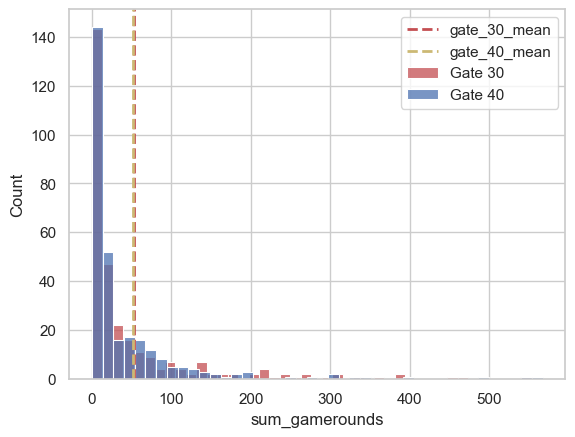

In [500]:
# Построим графики распредления суммы сыгранных раундов по группам
sns.histplot(data=df[df['version'] == 'gate_30']['sum_gamerounds'][:300], color='r')
plt.axvline(df[df['version'] == 'gate_30']['sum_gamerounds'].mean(), color='r', linestyle='dashed', linewidth=2)
sns.histplot(data=df[df['version'] == 'gate_40']['sum_gamerounds'][:300], color='b')
plt.axvline(df[df['version'] == 'gate_40']['sum_gamerounds'].mean(), color='y', linestyle='dashed', linewidth=2)
plt.legend(['gate_30_mean', 'gate_40_mean', 'Gate 30', 'Gate 40'])
plt.show()


In [501]:
# Проведем тест Манна-Уитни для разницы двух средних в группах
U = st.mannwhitneyu(df[df['version'] == 'gate_30']['sum_gamerounds'], df[df['version'] == 'gate_40']['sum_gamerounds'])
p_val = U[1]
if p_val < 0.05:
    print('Reject null hipothesis about differencies between means of two grous')
else:
    print("Can't reject null hipothesis about differencies between means of two groups")

Can't reject null hipothesis about differencies between means of two groups


Оценим мощность теста

In [503]:
# Расчитаем описательные статистики
gate30_mean = df[df['version'] == 'gate_30']['sum_gamerounds'].mean()
gate40_mean = df[df['version'] == 'gate_40']['sum_gamerounds'].mean()

gate30_std = df[df['version'] == 'gate_30']['sum_gamerounds'].std()
gate40_std = df[df['version'] == 'gate_40']['sum_gamerounds'].std()


(256.7164231160407, 103.29441621652788)

In [505]:
# Выберем меньшую длину из выборок
sample_length = len(df[df['version'] == 'gate_30']['sum_gamerounds'])

44700

In [507]:
# Standart deviation pool
S = np.sqrt((gate30_std**2 + gate40_std **2)/ 2)


195.66943849130774

In [516]:
ef =float((gate40_mean-gate30_mean)/ S) 
print(f'Effect = {ef}')

Effect = -0.005915530104639557


In [523]:
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = smp.tt_ind_solve_power(effect_size=ef, nobs1=sample_length, alpha=alpha, power=None )

analysis # Очень низкая мощность теста

0.1432769062259385

# Выводы
По результатам данных А/В теста не удалось получить статистически значимых различий в количестве сыгранных раундов между группами и возвратом на первые сутки (retention_1). Удалось установить статистически значимые различия между группами и возвратом на 7 сутки (retention_7).
Для увеличения мощности теста необходимо увеличить количество пользователей в выборках